In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [29]:
customers = pd.read_csv(r"C:\Users\admin\Downloads\Customers.csv")
transactions = pd.read_csv(r"C:\Users\admin\Downloads\Transactions.csv")

In [31]:
# Merge datasets
merged_data = pd.merge(transactions, customers, on="CustomerID", how="inner")

In [33]:
merged_data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
...,...,...,...,...,...,...,...,...,...,...
995,T00774,C0095,P056,2024-01-07 14:19:49,2,32.16,16.08,William Walker,South America,2023-03-04
996,T00823,C0095,P079,2024-09-30 10:45:06,3,1252.11,417.37,William Walker,South America,2023-03-04
997,T00369,C0151,P082,2024-12-24 11:40:24,4,223.96,55.99,Amber Gonzalez,South America,2024-11-22
998,T00809,C0078,P075,2024-12-09 11:44:44,2,995.52,497.76,Julia Palmer,Asia,2024-11-13


In [35]:
# Calculate total spend, frequency, and average transaction value for each customer
customer_features = merged_data.groupby("CustomerID").agg(
    total_spend=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    customer_lifespan=("TransactionDate", lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days + 1)
).reset_index()

In [37]:
customer_features = customer_features.merge(customers, on="CustomerID", how="left")

In [39]:
customer_features

,CustomerID,total_spend,transaction_count,avg_transaction_value,customer_lifespan,CustomerName,Region,SignupDate
0,C0001,3354.52,5,670.904000,289,Lawrence Carroll,South America,2022-07-10
1,C0002,1862.74,4,465.685000,279,Elizabeth Lutz,Asia,2022-02-13
2,C0003,2725.38,4,681.345000,189,Michael Rivera,South America,2024-03-07
3,C0004,5354.88,8,669.360000,300,Kathleen Rodriguez,South America,2022-10-09
4,C0005,2034.24,3,678.080000,234,Laura Weber,Asia,2022-08-15
...,...,...,...,...,...,...,...,...
194,C0196,4982.88,4,1245.720000,131,Laura Watts,Europe,2022-06-07
195,C0197,1928.65,3,642.883333,350,Christina Harvey,Europe,2023-03-21
196,C0198,931.83,2,465.915000,6,Rebecca Ray,Europe,2022-02-27
197,C0199,1979.28,4,494.820000,70,Andrea Jenkins,Europe,2022-12-03


In [41]:
from sklearn.preprocessing import LabelEncoder

In [43]:
label_encoder = LabelEncoder()

# label encoding to Region column
customer_features["Region"] = label_encoder.fit_transform(customer_features["Region"])

# View the encoded values
print(customer_features[["Region"]].head())

   Region
0       3
1       0
2       3
3       3
4       0


In [45]:
# Prepare data for clustering
features = customer_features.drop(columns=["CustomerID", "CustomerName", "SignupDate"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [47]:
# Clustering
num_clusters = range(2, 11)
db_scores = []

In [49]:
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)

In [51]:
# Optimal number of clusters based on DB Index
optimal_clusters = num_clusters[np.argmin(db_scores)]

In [53]:
# Fit final KMeans model
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = final_kmeans.fit_predict(scaled_features)

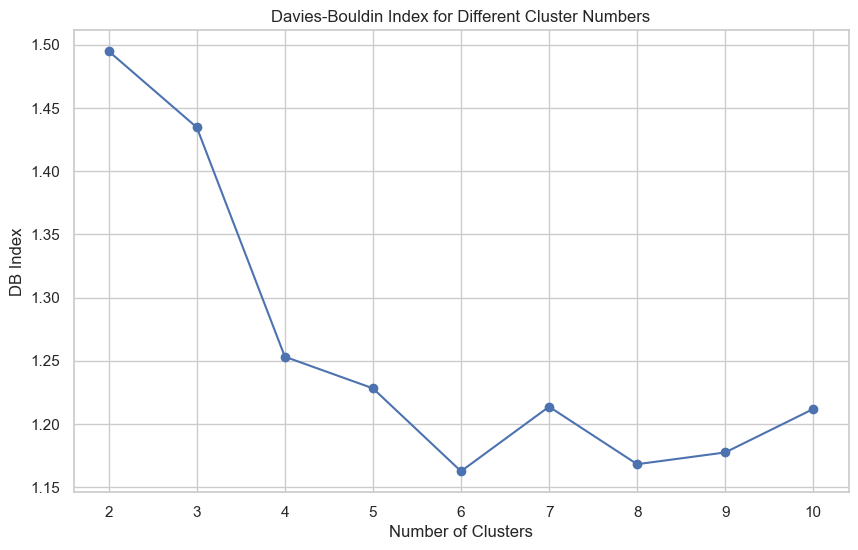

In [55]:
# Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, db_scores, marker="o")
plt.title("Davies-Bouldin Index for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(num_clusters)
plt.show()

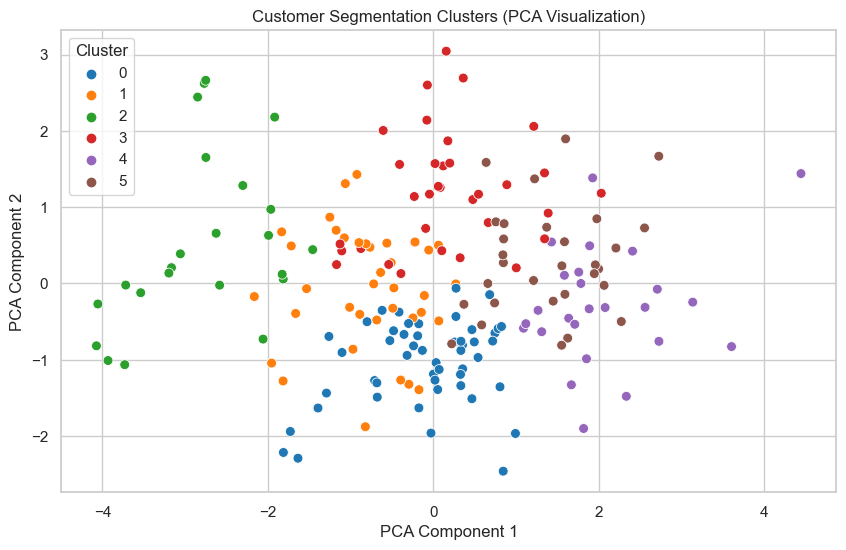

In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=customer_features["Cluster"],
    palette="tab10",
    s=50
)
plt.title("Customer Segmentation Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [61]:
customer_features.to_csv("Customer_Segmentation_Results.csv", index=False)


In [63]:
print("Optimal number of clusters:", optimal_clusters)
print("Davies-Bouldin Index for optimal clusters:", min(db_scores))

Optimal number of clusters: 6
Davies-Bouldin Index for optimal clusters: 1.1625965909895746
